In [1]:

import time
import warnings
import numpy as np
import pywt
import os
import scipy.io as sio
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from operator import truediv
import spectral
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Concatenate, Input, Flatten,
                                     Reshape, Lambda)
from tensorflow.keras.layers import Input, Conv3D, Conv2D, BatchNormalization, GlobalAveragePooling2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

2024-12-23 15:26:20.359215: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 15:26:20.383516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 15:26:20.383545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 15:26:20.384577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 15:26:20.391052: I tensorflow/core/platform/cpu_feature_guar

In [2]:
## Important Parameters
num_epochs = 50
batch_size = 256
k = 15
WS = 10
teRatio = 0.50
vrRatio = 0.25
trRatio = 0.25
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)



/home/arslan/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:

def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'./datasets')
    if method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
    elif method == 'UH':
        HSI = sio.loadmat(os.path.join(data_path, 'HU13.mat'))['HSI']
        GT = sio.loadmat(os.path.join(data_path, 'HU13_gt.mat'))['gt']
        Num_Classes = 15
    return HSI, GT, Num_Classes

In [4]:
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

## 3-D HSI slices
def ImageCubes(HSI, GT, WS = WS, removeZeroLabels = True):
    margin = int((WS) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    ## split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin, c - margin:c + margin]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

## Padding around HSI
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch

In [5]:

def ClassificationReports(TeC, HSID, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    if HSID == 'HC':
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    elif HSID == 'UH':
        target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

## Writing Results in CSV files
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(oa))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(aa))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(each_acc))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(confusion))
    return CSV_file

## Plot Ground Truths
def GT_Plot(CRDHSI, GT, model, WS, k):
  Predicted = model.predict(CRDHSI)
  Predicted = np.argmax(Predicted, axis=1)
  height, width = np.shape(GT)
  ## Calculate the predicted Ground Truths
  outputs = np.zeros((height, width))
  count = 0
  for AA in range(height):
    for BB in range(width):
      target = int(GT[AA,BB])
      if target == 0:
        continue
      else:
        outputs[AA][BB] = Predicted[count]
        count = count+1
  return outputs

In [6]:
def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    # Split into train and test sets
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    # Calculate the validation ratio based on the updated test and train ratios
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    # Split train set into train and validation sets
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)

    return Tr, Va, Te, TrC, VaC, TeC

In [7]:
## Global Parameters
HSID = "UH" ## ""HC"
DLM = "PCA"
output_dir = os.path.join(f"Wavemamba/{HSID}/")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
## Main Function to load Datasets, Dimensional Reduction and Creating Patchs for CNN
HSI, GT, Num_Classes = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train/validation and Test sets
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
# Reshape train, validation, and test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = to_categorical(TrC)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = to_categorical(VaC)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = to_categorical(TeC)

In [8]:
class SpectralSpatialTokenGeneration(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):
        super(SpectralSpatialTokenGeneration, self).__init__(**kwargs)
        self.spatial_tokens = Dense(out_channels)
        self.spectral_tokens = Dense(out_channels)
    def call(self, x):
        B, H, W, C = x.shape
        # Use tf.shape to handle dynamic batch dimension
        spatial_tokens = self.spatial_tokens(tf.reshape(tf.transpose(x, [0, 2, 3, 1]), [tf.shape(x)[0], H * W, C]))
        spectral_tokens = self.spectral_tokens(tf.reshape(tf.transpose(x, [0, 1, 2, 3]), [tf.shape(x)[0], H * W, C]))
        return spatial_tokens,spectral_tokens

class SpectralSpatialFeatureEnhancement(tf.keras.layers.Layer):
    def __init__(self, out_channels, **kwargs):  # Add 'self'
        super(SpectralSpatialFeatureEnhancement, self).__init__(**kwargs)
        self.spatial_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            # Reshape the output to match spatial_tokens
            Reshape((1, out_channels))
        ])
        self.spectral_gate = Sequential([
            Dense(out_channels),
            Activation('sigmoid'),
            # Reshape the output to match spectral_tokens
            Reshape((1, out_channels))
        ])
    def call(self, spatial_tokens, spectral_tokens, center_tokens):
        spatial_enhanced = spatial_tokens * self.spatial_gate(center_tokens)
        spectral_enhanced = spectral_tokens * self.spectral_gate(center_tokens)
        return spatial_enhanced, spectral_enhanced

class StateSpaceModel(tf.keras.layers.Layer):
    def __init__(self, state_dim, **kwargs):
        super(StateSpaceModel, self).__init__(**kwargs)
        self.state_dim = state_dim
        self.state_transition = Dense(units=state_dim, activation="relu")
        self.state_update = Dense(units=state_dim, activation="relu")
    def call(self, x):
        state = tf.zeros([tf.shape(x)[0], self.state_dim])
        for t in range(tf.shape(x)[1]):
            # Flatten the input if it has more than 2 dimensions
            input_t = tf.reshape(x[:, t, :], [tf.shape(x)[0], -1])
            state = self.state_transition(state) + self.state_update(input_t)
        return state

class SSMambaModel(tf.keras.Model):
    def __init__(self, out_channels, num_heads, state_dim, Num_Classes, dropout=0.1, **kwargs):
        super(SSMambaModel, self).__init__(**kwargs)
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        self.feature_enhancement = SpectralSpatialFeatureEnhancement(out_channels)
        self.state_space_model = StateSpaceModel(state_dim)
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def apply_wavelet_transform(self, image, wavelet_name='haar'):
        """'haar', 'db1', 'db2', 'coif1', 'bior1.3'"""
        image_np = tf.make_ndarray(tf.make_tensor_proto(image))
        if wavelet_name not in pywt.wavelist(kind='discrete'):
            raise ValueError(f"The wavelet {wavelet_name} is not supported for discrete wavelet transform.")
        coeffs = pywt.dwt2(image_np, wavelet_name)
        cA, (cH, cV, cD) = coeffs
        transformed = np.stack([cA, cH, cV, cD], axis=-1)
        return tf.convert_to_tensor(transformed, dtype=tf.float32)
    def call(self, x):
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]
        spatial_tokens, spectral_tokens = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        spatial_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spatial_tokens, dtype=tf.float32)
        spectral_tokens = tf.map_fn(lambda t: tf.numpy_function(self.apply_wavelet_transform, [t], tf.float32), spectral_tokens, dtype=tf.float32)
        Combined_Tokens = tf.concat([spatial_tokens, spectral_tokens], axis=-1)
        state_output = self.state_space_model(Combined_Tokens)
        output = self.classifier(state_output)
        return output

def WaveMamba(Tr, batch_size, Num_Classes):
    model = SSMambaModel(out_channels=64, num_heads=4, state_dim=128, Num_Classes=Num_Classes, dropout=0.1)
    sample_input = Tr[:batch_size]
    _ = model(sample_input)
    return model

In [11]:
class SplineLinear(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, init_scale=0.1, **kwargs):
        super().__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.init_scale = init_scale
        self.weight = self.add_weight(
            shape=(self.out_features, self.in_features),
            initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=init_scale),
            trainable=True, regularizer=tf.keras.regularizers.l2(0.001)
        )
    def call(self, inputs):
        return tf.matmul(inputs, tf.transpose(self.weight))

class RadialBasisFunction(tf.keras.layers.Layer):
    def __init__(self, grid_min=-2.0, grid_max=2.0, num_grids=25, denominator=None, **kwargs):
        super().__init__(**kwargs)
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)
        self.grid = tf.Variable(
            initial_value=tf.linspace(grid_min, grid_max, num_grids),
            trainable=False,
            name="grid"
        )
    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        return tf.exp(-((expanded_inputs - self.grid) / self.denominator) ** 2)
    
class FastKANLayer(tf.keras.layers.Layer):
    def __init__(self, 
                 input_dim, output_dim, 
                 grid_min=-2.0, grid_max=2.0, 
                 num_grids=25, use_base_update=True, 
                 use_layernorm=True, base_activation=tf.nn.relu, 
                 spline_weight_init_scale=0.1, 
                 **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_layernorm = use_layernorm
        self.use_base_update = use_base_update
        self.base_activation = base_activation
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = tf.keras.layers.LayerNormalization(axis=-1)
        else:
            self.layernorm = None
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, init_scale=spline_weight_init_scale)

        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = tf.keras.layers.Dense(output_dim)

    def call(self, inputs, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            normalized_inputs = self.layernorm(inputs)
        else:
            normalized_inputs = inputs
        spline_basis = self.rbf(normalized_inputs)
        spline_basis_flat = tf.reshape(
            spline_basis,
            shape=(-1, spline_basis.shape[-2] * spline_basis.shape[-1])
        )
        ret = self.spline_linear(spline_basis_flat)
        ret = tf.reshape(ret, shape=tf.shape(inputs)) 
        # ret = tf.reshape(ret, [-1, ret.shape[-1]])  # Adjust as needed, e.g., flattening over axes
        if self.use_base_update:
            base = self.base_linear(self.base_activation(inputs))
            ret = ret + base
        return ret
class FastKolmogorovAttentionMultiHead(tf.keras.layers.Layer):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 num_heads, 
                 num_layers=4,  # Number of attention layers to stack
                 grid_min=-2.0, 
                 grid_max=2.0, 
                 num_grids=25, 
                 use_layernorm=True, 
                 spline_weight_init_scale=0.1, 
                 base_activation=tf.nn.silu, 
                 dropout=0.1, 
                 **kwargs):
        super(FastKolmogorovAttentionMultiHead, self).__init__(**kwargs)
        
        self.num_heads = num_heads
        self.output_dim = output_dim
        self.head_dim = output_dim // num_heads
        self.num_layers = num_layers  # Set number of layers
        assert output_dim % num_heads == 0, "Output dimension must be divisible by the number of heads."
        # Scaling factor for attention scores
        self.scale = self.head_dim ** -0.5
        
        # Custom layers for feature transformation before attention
        self.query_layer = FastKANLayer(input_dim, input_dim, grid_min, grid_max, num_grids, 
                                        use_layernorm=use_layernorm, spline_weight_init_scale=spline_weight_init_scale,
                                        base_activation=base_activation)
        self.key_layer = FastKANLayer(input_dim, input_dim, grid_min, grid_max, num_grids, 
                                      use_layernorm=use_layernorm, spline_weight_init_scale=spline_weight_init_scale,
                                      base_activation=base_activation)
        self.value_layer = FastKANLayer(input_dim, input_dim, grid_min, grid_max, num_grids, 
                                        use_layernorm=use_layernorm, spline_weight_init_scale=spline_weight_init_scale,
                                        base_activation=base_activation)
        # Output projection layer
        self.output_projection = tf.keras.layers.Dense(output_dim)
        self.dropout = Dropout(dropout)
    
    def call(self, query, key=None, value=None):
        if key is None:
            key = query
        if value is None:
            value = query
        batch_size = tf.shape(query)[0]
        # Apply FastKAN to queries, keys, and values
        query_proj = self.query_layer(query)  # Shape: [batch_size, seq_len, input_dim]
        key_proj = self.key_layer(key)        # Shape: [batch_size, seq_len, input_dim]
        value_proj = self.value_layer(value)  # Shape: [batch_size, seq_len, input_dim]
        # Initialize the attention output as the original values
        attention_output = value_proj
        # Stacked attention layers
        for _ in range(self.num_layers):
            # Reshape into [batch_size, seq_len, num_heads, head_dim] for multi-head attention
            query_proj = tf.reshape(query_proj, [batch_size, -1, 1, self.head_dim])  # One query for all heads
            query_proj = tf.transpose(query_proj, [0, 2, 1, 3])  # [batch_size, 1, seq_len, head_dim]
            key_proj = tf.reshape(key_proj, [batch_size, -1, self.num_heads, self.head_dim])
            key_proj = tf.transpose(key_proj, [0, 2, 1, 3])  # [batch_size, num_heads, seq_len, head_dim]
            value_proj = tf.reshape(value_proj, [batch_size, -1, self.num_heads, self.head_dim])
            value_proj = tf.transpose(value_proj, [0, 2, 1, 3])  # [batch_size, num_heads, seq_len, head_dim]
            # Scaled dot-product attention for each head (using the same query for all heads)
            attention_scores = tf.matmul(query_proj, key_proj, transpose_b=True) / tf.sqrt(tf.cast(self.head_dim, tf.float32))
            attention_weights = tf.nn.softmax(attention_scores, axis=-1)  # [batch_size, 1, seq_len, seq_len]
            attention_output = tf.matmul(attention_weights, value_proj)  # [batch_size, num_heads, seq_len, head_dim
            # Concatenate heads back: [batch_size, seq_len, num_heads * head_dim]
            attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # [batch_size, seq_len, num_heads, head_dim]
            attention_output = tf.reshape(attention_output, [batch_size, -1, self.num_heads * self.head_dim])  # [batch_size, seq_len, output_dim]
        # Apply output projection
        attention_output = self.output_projection(attention_output)
        # Apply dropout
        attention_output = self.dropout(attention_output)
        
        return attention_output
class SSFKSMambaModel(tf.keras.Model):
    def __init__(self, out_channels=64, state_dim=128, num_heads=2,num_layers=4,num_grids =25, dropout=0.1,**kwargs):
        super(SSFKSMambaModel, self).__init__(**kwargs)
        # Tokenization
        self.token_generation = SpectralSpatialTokenGeneration(out_channels)
        # FastKolmogorovAttention
        self.fast_kan_attention = FastKolmogorovAttentionMultiHead(input_dim=out_channels,output_dim=out_channels,num_heads=num_heads,
                                                                   grid_min=-2.0,grid_max=2.0,num_layers=num_layers, num_grids=num_grids,use_layernorm=True,
                                                                   dropout=0.1,spline_weight_init_scale=0.1,
                                                                   base_activation=tf.nn.relu,
        )
        # Feature Enhancement
        self.feature_enhancement = SpectralSpatialFeatureEnhancement(out_channels)
        # State Space Model using Transformer
        self.state_space_model = StateSpaceModel(state_dim)
        # Dense Layers and Classification
        self.dense = Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout = Dropout(0.4)
        self.classifier = Dense(Num_Classes, activation='softmax')
    def call(self, x, training=False):
        # Step 1: Tokenization
        spatial_tokens, spectral_tokens = self.token_generation(x)
        center_tokens = spatial_tokens[:, x.shape[1] // 2, :]  # Center tokens for gating
        # Step 2: Feature Enhancement
        spatial_enhanced, spectral_enhanced = self.feature_enhancement(spatial_tokens, spectral_tokens, center_tokens)
        # Step 3: Apply FstKolmogorovAttention
        spatial_attention = self.fast_kan_attention(spatial_enhanced)
        spectral_attention = self.fast_kan_attention(spectral_enhanced)
        # Step 5: Combine the outputs
        combined_output = tf.concat([spatial_attention, spectral_attention], axis=-1)
        # Step 6: State Space Modeling using Transformer
        state_output = self.state_space_model(combined_output)
        # Step 7: Dense layer and classification
        output = self.classifier(state_output )
        return output
def FastKanMamba(Tr, batch_size):
    model = SSFKSMambaModel(
        out_channels=64,
        state_dim=128,
        num_heads=8,
        num_layers=4,
        num_grids=25,
        dropout=0.1
    )
    # Build the model by passing a batch of data
    _ = model(Tr[:batch_size])  # Ensures model is built correctly
    return model


In [12]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam, CRDHSI, HSID, teRatio, k, WS, DLM, RDHSI, GT,Num_Classes,batch_size,epochs):
    print(f"Model name: {model_name}")    
    if model_name == WaveMamba:
      ## Transform Training/Validation/Test samples
      Tr = Tr.reshape(-1, WS, WS, k)
      Va = Va.reshape(-1, WS, WS, k)
      Te = Te.reshape(-1, WS, WS, k)
      model = WaveMamba(Tr, batch_size, Num_Classes)
    elif model_name == FastKanMamba:
      ## Transform Training/Validation/Test samples
      Tr = Tr.reshape(-1, WS, WS, k)
      Va = Va.reshape(-1, WS, WS, k)
      Te = Te.reshape(-1, WS, WS, k)
      model = FastKanMamba(Tr, batch_size)
    else:
      model = model_name(WS, k, Num_Classes)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    start = time.time()
    history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    end = time.time()
    Tr_Time = end - start
    start = time.time()
    Te_Pred = model.predict(Te)
    end = time.time()
    Te_Time = end - start
    classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, HSID, Te_Pred)
    print(classification)
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Report_{model_name.__name__}.csv"
    CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
    outputs = GT_Plot(CRDHSI, GT, model, WS, k)
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_Ground_Truths_{model_name.__name__}.png"
    plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
    return history

Model name: <function FastKanMamba at 0x7fbcda684820>


2024-12-23 15:26:25.722147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 15:26:25.798434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 15:26:25.798470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 15:26:25.801200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-23 15:26:25.801235: I external/local_xla/xla/stream_executor

Model: "ssfks_mamba_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_spatial_token_gen  multiple                  2048      
 eration (SpectralSpatialTo                                      
 kenGeneration)                                                  
                                                                 
 fast_kolmogorov_attention_  multiple                  324299    
 multi_head (FastKolmogorov                                      
 AttentionMultiHead)                                             
                                                                 
 spectral_spatial_feature_e  multiple                  8320      
 nhancement (SpectralSpatia                                      
 lFeatureEnhancement)                                            
                                                                 
 state_space_model (StateSp  multiple            

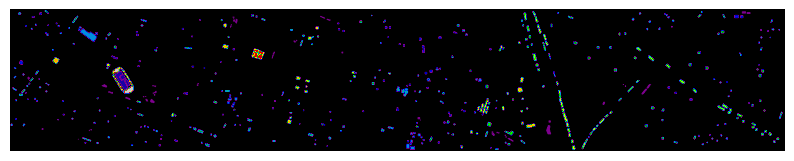

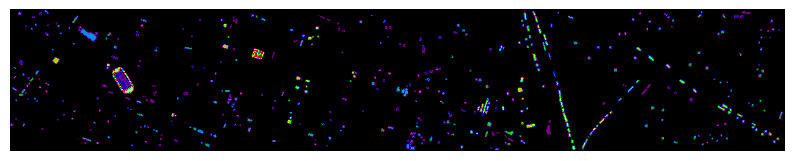

In [13]:
# model_names = [CNN2D,IN2D,HybIN,IN3D,HybCNN,WaveMamba]
model_names = [FastKanMamba,WaveMamba]
history_list = []
features_list = []
Labels_list = []
for model_name in model_names:
  history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS,
                                       DLM, RDHSI, GT, Num_Classes, batch_size, num_epochs)
  history_list.append(history)

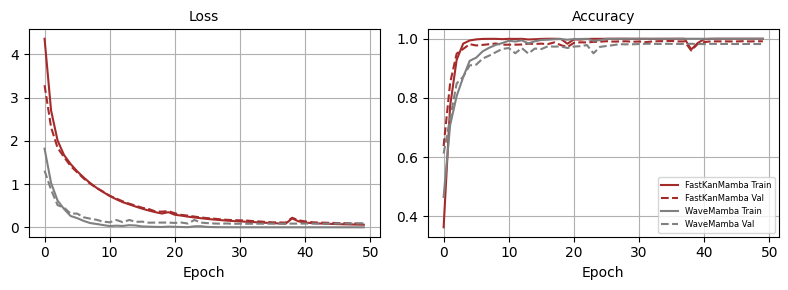

In [14]:
# Plot training and validation loss and accuracy for each model
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
colors = ['brown', 'gray', 'blue', 'green', 'purple', 'orange', 'red']

for i, history in enumerate(history_list):
    # Plot loss
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[0].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[1].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
axs[0].set_title('Loss', fontsize=10)
axs[0].set_xlabel('Epoch', fontsize=10)
axs[1].set_title('Accuracy', fontsize=10)
axs[1].set_xlabel('Epoch', fontsize=10)
axs[1].legend(fontsize=6)
axs[0].grid(True)
axs[1].grid(True)
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_acc_loss_curve_all_models.png"
plt.savefig(os.path.join(output_dir, file_name), dpi=500, format='png', bbox_inches='tight', pad_inches=0)